<a href="https://colab.research.google.com/github/KellieLeonard-Biostat/Isolation-and-Classification-of-Placental-Contractions/blob/main/Isolation_and_Classification_of_Placental_Contractions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

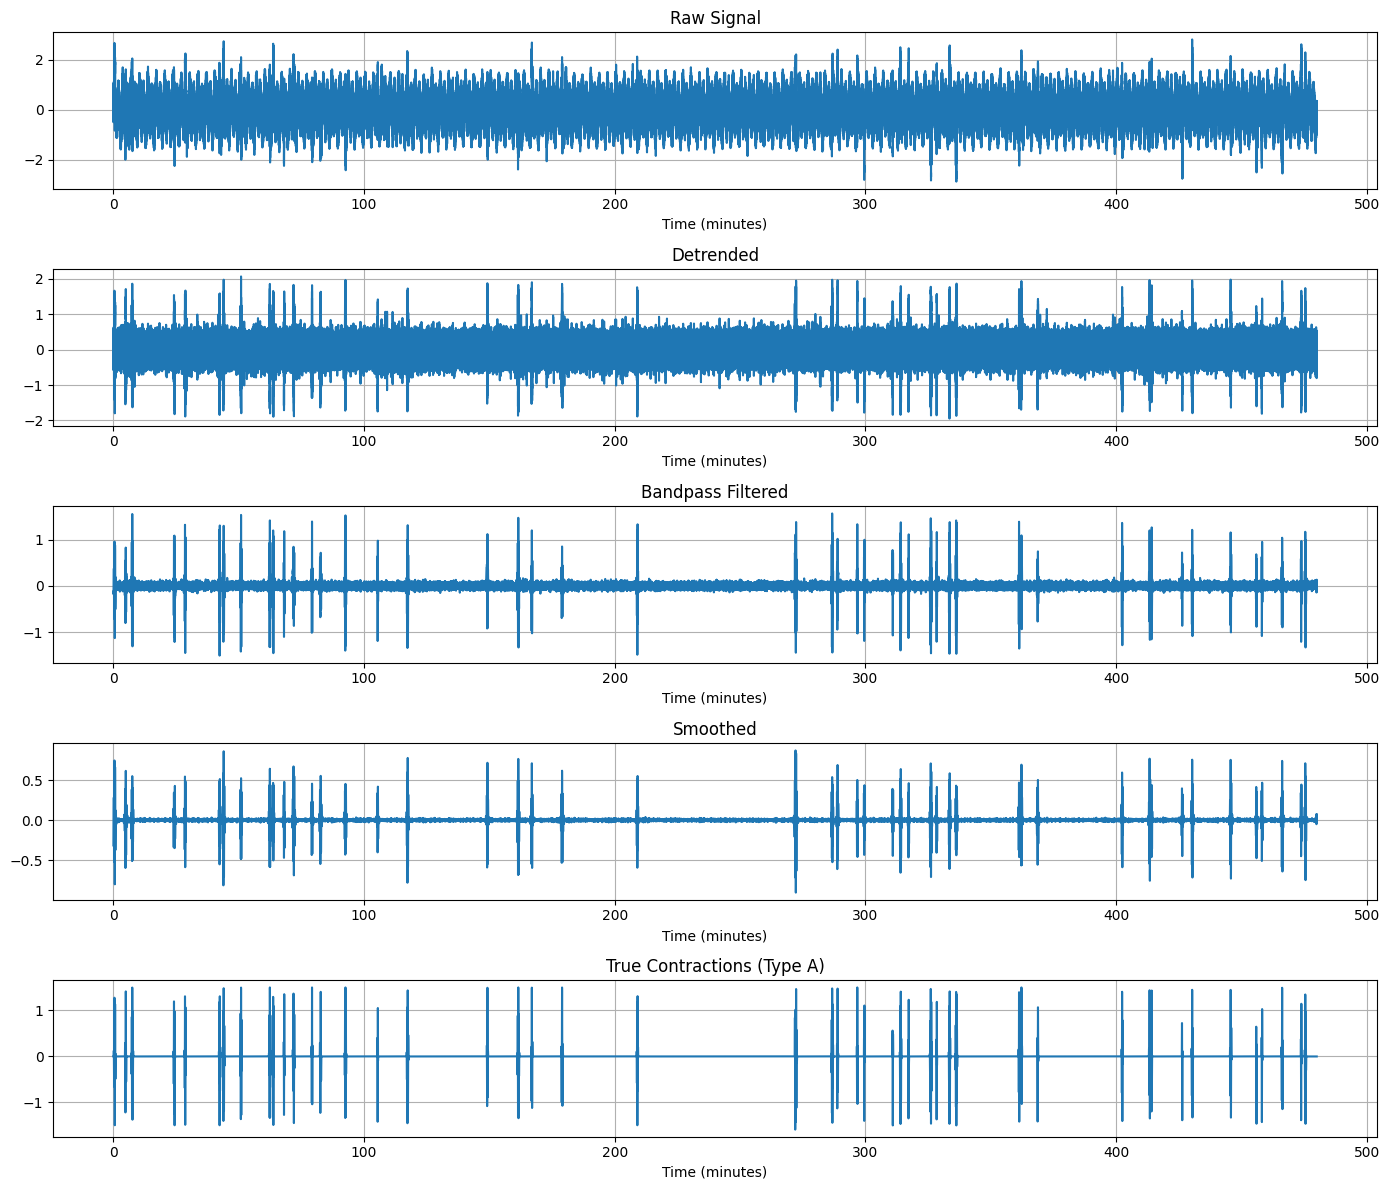

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter

# Sampling settings
fs = 20  # Hz
duration_hours = 8
duration_secs = duration_hours * 3600
t = np.linspace(0, duration_secs, int(duration_secs * fs))

# --- Signal Generators ---

def generate_multiple_contractions(t, fs, num_contractions=50):
    signal = np.zeros_like(t)
    for _ in range(num_contractions):
        start_idx = np.random.randint(0, len(t) - fs * 60)
        duration = np.random.randint(20 * fs, 60 * fs)
        end_idx = start_idx + duration
        if end_idx >= len(t):
            continue
        freq = np.random.uniform(0.05, 0.1)  # contraction freq range
        window = np.hanning(duration)
        contraction = 1.5 * np.sin(2 * np.pi * freq * np.linspace(0, duration/fs, duration)) * window
        signal[start_idx:end_idx] += contraction
    return signal

def generate_fetal_kicks(t, fs, num_kicks=100):
    signal = np.zeros_like(t)
    for _ in range(num_kicks):
        start_idx = np.random.randint(0, len(t) - fs)
        duration = np.random.randint(0.5 * fs, 2 * fs)
        freq = np.random.uniform(0.8, 2.0)
        kick = 0.6 * np.sin(2 * np.pi * freq * np.linspace(0, duration/fs, duration))
        signal[start_idx:start_idx + duration] += kick
    return signal

def generate_maternal_movement(t):
    drift = 0.8 * np.sin(2 * np.pi * 0.01 * t) + 0.3 * np.sin(2 * np.pi * 0.005 * t)
    return drift

def generate_noise(t):
    return 0.2 * np.random.normal(size=len(t))

# --- Generate Signal ---

contractions = generate_multiple_contractions(t, fs)
kicks = generate_fetal_kicks(t, fs)
movement = generate_maternal_movement(t)
noise = generate_noise(t)

raw_signal = contractions + kicks + movement + noise

# --- Preprocessing Steps ---

# Step 1: Detrending using Savitzky-Golay
detrended = raw_signal - savgol_filter(raw_signal, 1001, 3)

# Step 2: Bandpass filter to isolate 0.05–0.5 Hz (contraction range)
def bandpass_filter(signal, fs, lowcut=0.05, highcut=0.5, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

filtered = bandpass_filter(detrended, fs)

# Step 3: Smoothing
smoothed = savgol_filter(filtered, 301, 2)

# --- Plot a Sample Window  ---

sample_length = 3600 * 60 * fs
sample_t = t[:sample_length] / 60  # in minutes
signals = {
    'Raw Signal': raw_signal[:sample_length],
    'Detrended': detrended[:sample_length],
    'Bandpass Filtered': filtered[:sample_length],
    'Smoothed': smoothed[:sample_length],
    'True Contractions (Type A)': contractions[:sample_length],
}

plt.figure(figsize=(14, 12))
for i, (label, data) in enumerate(signals.items()):
    plt.subplot(len(signals), 1, i + 1)
    plt.plot(sample_t, data, label=label)
    plt.title(label)
    plt.xlabel('Time (minutes)')
    plt.grid(True)
    plt.tight_layout()

plt.show()


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.fft import fft
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Sampling settings
fs = 20
window_sec = 60
window_len = fs * window_sec

# -- Extracted from the previous code ---
# Assume these are already generated from the earlier script:
# t, raw_signal, contractions, smoothed

# Feature extraction for each window
def extract_features(window):
    features = {}
    features['mean'] = np.mean(window)
    features['std'] = np.std(window)
    features['max'] = np.max(window)
    features['min'] = np.min(window)
    features['rms'] = np.sqrt(np.mean(window**2))
    features['entropy'] = entropy(np.histogram(window, bins=20)[0] + 1)

    # FFT-based features
    fft_vals = np.abs(fft(window))
    fft_freqs = np.fft.fftfreq(len(window), 1/fs)
    fft_vals = fft_vals[:len(fft_vals)//2]
    fft_freqs = fft_freqs[:len(fft_freqs)//2]
    band_power = np.sum(fft_vals[(fft_freqs > 0.05) & (fft_freqs < 0.5)])
    features['band_power_0.05_0.5Hz'] = band_power
    return features

# Label generation: if any contraction exists in a window, label = 1
def label_window(contraction_window, threshold=0.3):
    return 1 if np.max(np.abs(contraction_window)) > threshold else 0

# Segment and extract features + labels
X = []
y = []
for start in range(0, len(smoothed) - window_len, window_len):
    end = start + window_len
    segment = smoothed[start:end]
    contraction_segment = contractions[start:end]
    feats = extract_features(segment)
    label = label_window(contraction_segment)
    X.append(feats)
    y.append(label)

df = pd.DataFrame(X)
labels = np.array(y)

# Split and train classifier
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00         8

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



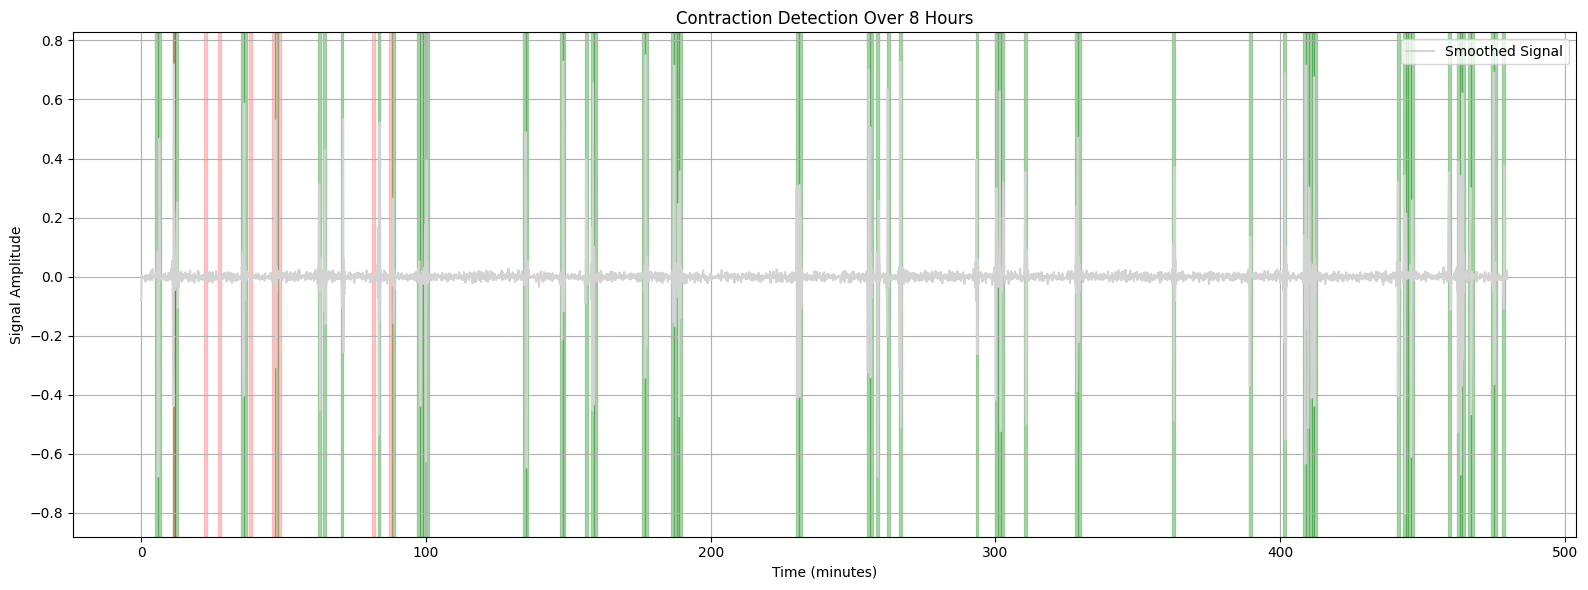

In [3]:
# Reconstruct time axis per window
window_duration = window_len / fs  # seconds
times = np.arange(0, len(labels)) * window_duration / 60  # in minutes

# Visualize
plt.figure(figsize=(16, 6))

# Plot smoothed signal (downsampled for visual clarity)
plot_every = int(fs * 10)  # every 10 seconds
time_axis = np.arange(len(smoothed)) / fs / 60
plt.plot(time_axis[::plot_every], smoothed[::plot_every], color='lightgray', label='Smoothed Signal')

# Overlay true contractions
for i, label in enumerate(labels):
    if label == 1:
        plt.axvspan(times[i], times[i]+window_duration/60, color='green', alpha=0.3, label='True Contraction' if i == 0 else "")

# Overlay predicted contractions
for i, pred in enumerate(y_pred):
    if pred == 1:
        plt.axvspan(times[i], times[i]+window_duration/60, color='red', alpha=0.2, label='Predicted Contraction' if i == 0 else "")

plt.title("Contraction Detection Over 8 Hours")
plt.xlabel("Time (minutes)")
plt.ylabel("Signal Amplitude")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
